Project : Face Mask Detection Using Deep Learning

**Authors:** Shivani Ghatge, Prateek Chitpur, Vinaya Chinti 

**Course Project Professor’s Name** : Vadim Sokolov

**Course Name:** OR-610 Deep Learning: Predictive Analytics

In [1]:
#import libraries for the project
import torch 
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor , Normalize
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import gc 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Setting the image directory path
use_gpu = torch.cuda.is_available()
img_data_dir = Path('Face Mask Dataset')
print("The folders in the root directory:",os.listdir(img_data_dir))

The folders in the root directory: ['Validation', 'Train', 'Test']


In [4]:
#Setting the path for the Train data
train_ds = img_data_dir/'Train'
classes = os.listdir(train_ds)
print("Classes for the Training Data:",classes)

Classes for the Training Data: ['WithoutMask', 'WithMask']


In [5]:
#Setting the path for the Validation data
val_ds = img_data_dir/'Validation'
classes = os.listdir(val_ds)
print("Classes for the Validation Data:",classes)

Classes for the Validation Data: ['WithoutMask', 'WithMask']


In [6]:
#Setting the path for the Test data
test_ds = img_data_dir/'Test'
classes = os.listdir(test_ds)
print("Classes for the Testing Data:",classes)

Classes for the Testing Data: ['WithoutMask', 'WithMask']


In [7]:
#Assigning labels to the images
train_maskPath = train_ds/'WithMask'
train_nonMaskPath = train_ds/'WithoutMask'
train_maskDF = pd.DataFrame()
train_path_dirs = [ [train_maskPath,1],[train_nonMaskPath,0] ] #path and label
if not os.path.exists(img_data_dir):
    raise Exception("The data path doesn't exist")

In [8]:
#Assigning labels to the images
val_maskPath = val_ds/'WithMask'
val_nonMaskPath = val_ds/'WithoutMask'
val_maskDF = pd.DataFrame()
val_path_dirs = [ [val_maskPath,1],[val_nonMaskPath,0] ] #path and label
if not os.path.exists(img_data_dir):
    raise Exception("The data path doesn't exist")

In [9]:
#Assigning labels to the images
test_maskPath = test_ds/'WithMask'
test_nonMaskPath = test_ds/'WithoutMask'
test_maskDF = pd.DataFrame()
test_path_dirs = [ [test_maskPath,1],[test_nonMaskPath,0] ] #path and label
if not os.path.exists(img_data_dir):
    raise Exception("The data path doesn't exist")

**Loading the image data**

In [10]:
#Function to read the image data and create a list with image and its labels
def read_data(directory_path):
    img_dim = 100
    target_class = {'WithMask': 1,'WithoutMask': 0}
    data_withlabels = []
    for directory_data, target_label in directory_path:
        print('Reading from folder:',target_label)
        for folder in tqdm(os.listdir(directory_data)):
            folder_loc = os.path.join(directory_data, folder)
            try:
              img = cv2.imread(folder_loc)
              img = cv2.resize(img, (img_dim,img_dim))
              data_withlabels.append([np.array(img), target_label])

              if target_label == 1:
                  target_class['WithMask'] += 1
              if target_label == 0:
                  target_class['WithoutMask'] +=1
            except:
                pass
    np.random.shuffle(data_withlabels)
    return data_withlabels

In [11]:
#Calling function to read training data
training_data = read_data(train_path_dirs)

  2%|▏         | 85/5000 [00:00<00:05, 844.52it/s]

Reading from folder: 1


  4%|▍         | 208/5000 [00:00<00:02, 2078.27it/s]

Reading from folder: 0


100%|██████████| 5000/5000 [00:02<00:00, 2051.09it/s]


In [12]:
print("Number of samples in training data:",len(training_data))

Number of samples in training data: 10000


**Displaying sample images in training data**

WithMask


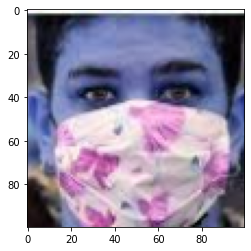

In [13]:
plt.imshow(training_data[50][0])
print(classes[training_data[50][1]])

WithoutMask


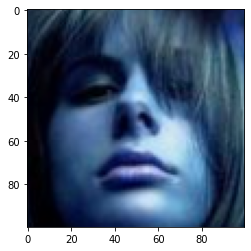

In [14]:
plt.imshow(training_data[405][0])
print(classes[training_data[405][1]])

In [15]:
#Calling function to read validation data data
val_data = read_data(val_path_dirs)

 22%|██▏       | 89/400 [00:00<00:00, 885.66it/s]

Reading from folder: 1


 53%|█████▎    | 211/400 [00:00<00:00, 2109.80it/s]

Reading from folder: 0


100%|██████████| 400/400 [00:00<00:00, 1980.59it/s]


In [16]:
print("Number of samples in validation data:",len(val_data))

Number of samples in validation data: 800


**Displaying sample images in validation data**

WithoutMask


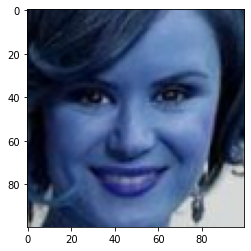

In [17]:
plt.imshow(val_data[110][0])
print(classes[val_data[110][1]])

WithMask


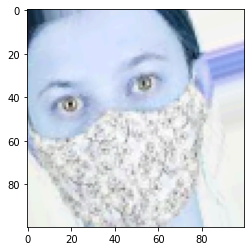

In [18]:
plt.imshow(val_data[40][0])
print(classes[val_data[40][1]])

In [19]:
#calling the function to read the test data
test_data = read_data(test_path_dirs)

 18%|█▊        | 89/483 [00:00<00:00, 881.32it/s]

Reading from folder: 1


 41%|████▏     | 211/509 [00:00<00:00, 2101.39it/s]

Reading from folder: 0


100%|██████████| 509/509 [00:00<00:00, 2088.24it/s]


In [20]:
print("Number of samples in testing data:",len(test_data))

Number of samples in testing data: 992


**Displaying sample images in testing data**

WithMask


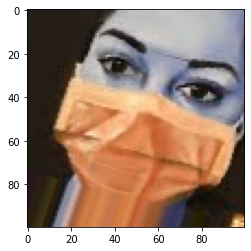

In [21]:
plt.imshow(test_data[40][0])
print(classes[test_data[40][1]])

WithoutMask


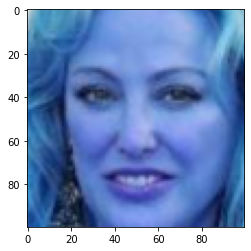

In [22]:
plt.imshow(test_data[118][0])
print(classes[test_data[118][1]])

In [23]:
torch.cuda.is_available()

True

**Transforming the image data**

In [24]:
#Function to tranform the image data
class transform_data(Dataset):
        def __init__(self, data):
            self.data = data
            self.transformations = Compose([
                ToTensor(),
                Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])
        
        def __getitem__(self, key):
            if isinstance(key, slice):
                raise NotImplementedError('Raise an exception')                    
            return [
                self.transformations(self.data[key][0]),
                torch.tensor(self.data[key][1])
            ]
        
        def __len__(self):
            return len(self.data)

In [25]:
#Tranforming the training data
trainDataset = transform_data(training_data)
trainDataset[5]

[tensor([[[-1.8268, -1.8439, -1.8439,  ..., -0.1828, -0.2171, -0.2171],
          [-1.8268, -1.8439, -1.8439,  ..., -0.3027, -0.3027, -0.3027],
          [-1.8268, -1.8439, -1.8439,  ..., -0.3541, -0.3541, -0.3541],
          ...,
          [-1.5528, -1.5528, -1.5528,  ..., -1.6213, -1.8782, -1.8782],
          [-1.6384, -1.6384, -1.6384,  ..., -1.5528, -1.8782, -1.8610],
          [-1.6555, -1.6555, -1.6727,  ..., -1.5357, -1.8782, -1.8610]],
 
         [[-1.6681, -1.7031, -1.7031,  ...,  0.1527,  0.1352,  0.1352],
          [-1.6856, -1.7031, -1.7031,  ...,  0.0651,  0.0301,  0.0126],
          [-1.6856, -1.7031, -1.7031,  ...,  0.0126, -0.0049, -0.0399],
          ...,
          [-1.4055, -1.4055, -1.4055,  ..., -1.4055, -1.7031, -1.6681],
          [-1.5105, -1.5105, -1.5105,  ..., -1.3354, -1.7031, -1.6681],
          [-1.5105, -1.5105, -1.5105,  ..., -1.3004, -1.7031, -1.6681]],
 
         [[-1.3339, -1.3687, -1.3687,  ...,  0.6531,  0.6182,  0.6008],
          [-1.3513, -1.3687,

In [26]:
#Tranforming the validation data
valDataset = transform_data(val_data)
valDataset[5]

[tensor([[[-1.2103, -1.2445, -1.2274,  ..., -1.4500, -2.0152, -1.8439],
          [-1.2274, -1.2445, -1.2445,  ..., -1.3815, -1.8953, -1.9638],
          [-1.1760, -1.1932, -1.1932,  ..., -1.2959, -1.6727, -1.9467],
          ...,
          [-1.2445, -1.2617, -1.1932,  ..., -1.9809, -1.9809, -1.9467],
          [-1.2788, -1.2617, -1.1760,  ..., -1.9809, -1.9809, -1.9467],
          [-1.2788, -1.2445, -1.1418,  ..., -1.9809, -1.9809, -1.9295]],
 
         [[-0.6702, -0.7052, -0.6877,  ..., -1.3179, -1.8957, -1.7206],
          [-0.6877, -0.7052, -0.7052,  ..., -1.2654, -1.7731, -1.8256],
          [-0.6352, -0.6527, -0.6527,  ..., -1.1604, -1.5455, -1.8256],
          ...,
          [-0.7227, -0.7402, -0.6702,  ..., -1.7556, -1.7731, -1.8081],
          [-0.7577, -0.7402, -0.6527,  ..., -1.7556, -1.7731, -1.8081],
          [-0.7577, -0.7227, -0.6176,  ..., -1.7556, -1.7731, -1.7906]],
 
         [[ 0.1128,  0.0779,  0.0953,  ..., -1.0724, -1.6476, -1.4733],
          [ 0.0953,  0.0779,

In [27]:
#Tranforming the testing data
testDataset = transform_data(test_data)
testDataset[5]

[tensor([[[ 1.4783,  1.4783,  1.4783,  ..., -0.9020, -1.1075, -1.1075],
          [ 1.4783,  1.4612,  1.4440,  ..., -0.8164, -1.1075, -0.9877],
          [ 1.4783,  1.4440,  1.4098,  ..., -0.7308, -1.0562, -0.9877],
          ...,
          [-1.0048, -1.3815, -1.4329,  ..., -1.8610, -1.7583, -1.6213],
          [-0.6623, -1.2445, -1.2788,  ..., -1.8953, -1.7069, -1.7240],
          [-0.1486, -0.8849, -1.1247,  ..., -1.8439, -1.7583, -1.7754]],
 
         [[ 1.2381,  1.2381,  1.2381,  ..., -0.7927, -1.0203, -0.9853],
          [ 1.2381,  1.2206,  1.1856,  ..., -0.7227, -1.0203, -0.8627],
          [ 1.2381,  1.2031,  1.1681,  ..., -0.6352, -0.9678, -0.8627],
          ...,
          [-0.7052, -1.1078, -1.1604,  ..., -1.6155, -1.5455, -1.4405],
          [-0.3901, -0.9853, -1.0028,  ..., -1.6506, -1.5105, -1.5455],
          [ 0.0476, -0.7052, -0.9503,  ..., -1.5980, -1.5455, -1.5805]],
 
         [[ 0.6705,  0.6531,  0.6356,  ..., -0.4973, -0.7238, -0.6890],
          [ 0.6705,  0.6356,

**Creating Dataloaders**

In [28]:
#Defining Batch size
batch_size = 64
#Defining input size
input_size = 100*100
#Defining output size
output_size = 2

In [29]:
#Dataloading for the train datasets
trainDataloader = DataLoader(trainDataset, batch_size, shuffle=True)
#Dataloading for the validation datasets
valDataloader = DataLoader(valDataset, batch_size)
#Dataloading for the test datasets
testDataloader = DataLoader(testDataset, batch_size)

In [30]:
#Function to calculate the accuracy
def calc_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [31]:
#check if cuda is available 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

**Image classification**

In [32]:
#Defining class for image classification
class Img_Classification(nn.Module):
    def train_step(self, batch):
        images, labels = batch 
        images=images.to(device)     #convert the images to cuda tensors
        labels=labels.to(device)     #covert the labels to cuda tensors
        out = self(images)                  
        loss = F.cross_entropy(out, labels.long()) 
        return loss
    
    def valid_step(self, batch):
        images, labels = batch 
        images=images.to(device)
        labels=labels.to(device)
        out = self(images)                   
        loss = F.cross_entropy(out, labels.long())   #calculate loss
        acc = calc_accuracy(out, labels)             #calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def valid_epoch(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epochstop(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [33]:
#Function to run the model in evaluation mode
@torch.no_grad()
def model_eval(model, valdata_loader):
    model.eval()
    output = [model.valid_step(batch) for batch in valdata_loader]
    return model.valid_epoch(output)

#Function to fit the model with specifies epochs and learning rate 
def model_fit(epochs, l_rate, model, trainDataloader, valDataloader, optim=torch.optim.SGD):
    trained_model = []
    optim_func = torch.optim.SGD(model.parameters(), l_rate, momentum=0.9)
    for epoch in range(epochs):
        # Training phase 
        print('Epoch: ', epoch)
        model.train()
        training_loss = []
        for batch in trainDataloader:
            loss = model.train_step(batch)
            training_loss.append(loss)
            loss.backward()
            optim_func.step()
            optim_func.zero_grad()
            gc.collect()
            torch.cuda.empty_cache()
        # Validation phase
        result = model_eval(model, valDataloader)
        result['train_loss'] = torch.stack(training_loss).mean().item()
        model.epochstop(epoch, result)
        trained_model.append(result)

    return trained_model

In [34]:
#Function to plot the model loss 
def graph_loss(model):
    loss = [x['val_loss'] for x in model]
    plt.plot(loss, '-x')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Number Of Epochs')

In [35]:
#Function to plot the model accuracy
def accuracy_graph(model):
    accuracy = [x['val_acc'] for x in model]
    plt.plot(accuracy, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of epochs')

In [36]:
#Funtion used for predicting the lable of images in test data
def Image_pred(path,saved_model, label= None, show= False):
    fig = plt.figure()
    images_trained = 0
    for i in range(len(path)):
        image = cv2.imread(path[i])      #read the image
        assert image is not None,"Corrupt Image"
        image = cv2.resize(image, (100, 100))      #resize the image
        image = torch.from_numpy(image)            #convert the image to array
        image = image.permute((2, 0,1)) 
        image = image.unsqueeze(dim=0).float()
        image = image.to(device)                  #specifying the device     
        predicted_class = saved_model(image)       
        _, predictions = torch.max(predicted_class, dim=1)     #making predictions
        images_trained += 1
        ax = plt.subplot(3,2,images_trained) 
        ax.axis('off')
        ax.set_title('predicted: {}'.format(classes[predictions.item()]))   #printing the class related to label
        plt.imshow(mpimg.imread(path[i]))

In [37]:
#Function to find the classification report and confusion matrix
def classificationReport(model):
  image_true_labels=[]
  test_image_paths=[]
  predicted_labels=[]
  target_names = [0,1]
  for directory_data, target_label in test_path_dirs:
          print('Reading from folder:',target_label)
          for folder in tqdm(os.listdir(directory_data)):
              folder_loc = os.path.join(directory_data, folder)
              image_true_labels.append(int(target_label))   #storing the true labels of images
              test_image_paths.append(folder_loc)
  for i in range(len(test_image_paths)):
    image = cv2.imread(test_image_paths[i])
    assert image is not None,"Corrupt Image"
    image = cv2.resize(image, (100, 100))
    image = torch.from_numpy(image)
    image = image.permute((2, 0,1)) 
    image = image.unsqueeze(dim=0).float()
    image = image.to('cuda') # Using the same device as the model
    predicted_class = model(image)
    _, predictions = torch.max(predicted_class, dim=1)
    predicted_labels.append(int(predictions.item()))      #storing the predicted labels of images 
  print(confusion_matrix(image_true_labels,predicted_labels))  #printing the confusion matrix
  print(classification_report(image_true_labels, predicted_labels,labels=[0,1])) #print the classification report 
        

**1.** **Convolutional Neural Network with 1 convolution layers, Batch Normalization and max pooling with fully connected layer**

In [38]:
#Defining class for Model 1
class cnn_maskdetect_convBatch(Img_Classification):
    def __init__(self):
        super().__init__()

        self.network_convBatch = nn.Sequential(  
            #Inuput_shape = [64 , 3, 100 , 100] 
            nn.Conv2d(in_channels = 3, out_channels = 100, kernel_size=3, padding=1, stride = 1),
            nn.BatchNorm2d(100),  #shape = [64 , 100, 100 , 100]
            nn.ReLU(),            #shape = [64 , 100, 100 , 100]
            nn.MaxPool2d(2, 2),   #shape = [64 , 100, 50 , 50]
            
            nn.Flatten(), 
            nn.Linear(100 * 50 * 50, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 2))
        
    def forward(self, inputs):
        return self.network_convBatch(inputs)

In [39]:
# Model 1
model1_convBatch = cnn_maskdetect_convBatch()
model1_convBatch.to(device)

cnn_maskdetect_convBatch(
  (network_convBatch): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=250000, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [40]:
model1_convBatch.eval()

cnn_maskdetect_convBatch(
  (network_convBatch): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=250000, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [41]:
convBatch = [model_eval(model1_convBatch, valDataloader)]
convBatch

[{'val_acc': 0.5192307829856873, 'val_loss': 0.691338062286377}]

In [42]:
#fiting the model with 10 epochs 
convBatch = model_fit(10, 1e-3, model1_convBatch, trainDataloader, valDataloader)

Epoch:  0
Epoch [0], train_loss: 0.1245, val_loss: 0.0377, val_acc: 0.9892
Epoch:  1
Epoch [1], train_loss: 0.0448, val_loss: 0.0340, val_acc: 0.9904
Epoch:  2
Epoch [2], train_loss: 0.0278, val_loss: 0.0271, val_acc: 0.9964
Epoch:  3
Epoch [3], train_loss: 0.0229, val_loss: 0.0314, val_acc: 0.9904
Epoch:  4
Epoch [4], train_loss: 0.0118, val_loss: 0.0300, val_acc: 0.9928
Epoch:  5
Epoch [5], train_loss: 0.0110, val_loss: 0.0207, val_acc: 0.9964
Epoch:  6
Epoch [6], train_loss: 0.0041, val_loss: 0.0256, val_acc: 0.9940
Epoch:  7
Epoch [7], train_loss: 0.0036, val_loss: 0.0214, val_acc: 0.9964
Epoch:  8
Epoch [8], train_loss: 0.0024, val_loss: 0.0208, val_acc: 0.9964
Epoch:  9
Epoch [9], train_loss: 0.0023, val_loss: 0.0226, val_acc: 0.9964


In [43]:
model_save_name = 'MaskDetectModel1.pth'
path = F"/content/drive/MyDrive/{model_save_name}" 

In [44]:
#saving the model on google drive 
torch.save(model1_convBatch,path)

In [45]:
#loading the saved model
saved_convBatch = torch.load(path)

In [46]:
#evaluating the saved model
saved_convBatch.eval()

cnn_maskdetect_convBatch(
  (network_convBatch): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=250000, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=2, bias=True)
  )
)

Loss for network with single convolutional layer


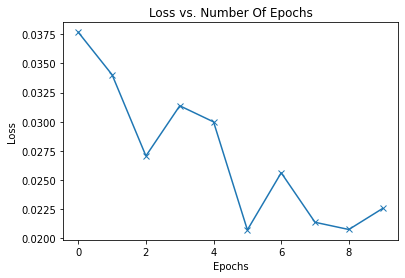

In [47]:
print("Loss for network with single convolutional layer")
graph_loss(convBatch)

Accuracy for network with single convolutional layer


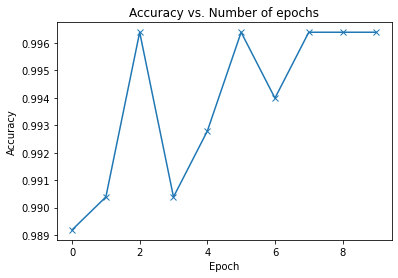

In [48]:
print("Accuracy for network with single convolutional layer")
accuracy_graph(convBatch)

In [49]:
#storing the image paths of images from testing data for prediction
test_image_paths=[]
for directory_data, target_label in test_path_dirs:
        print('Reading from folder:',target_label)
        for folder in tqdm(os.listdir(directory_data)):
            folder_loc = os.path.join(directory_data, folder)
            test_image_paths.append(folder_loc)
np.random.shuffle(test_image_paths)

100%|██████████| 509/509 [00:00<00:00, 132553.13it/s]

Reading from folder: 1
Reading from folder: 0


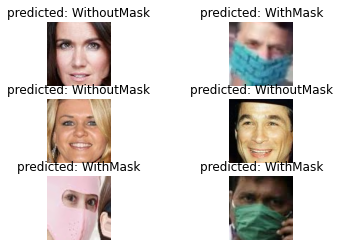

In [50]:
#Predictions on the test data
Image_pred(test_image_paths[17:23],saved_convBatch, show=True)

In [51]:
#Displaying the Classification Report
classificationReport(saved_convBatch)

100%|██████████| 509/509 [00:00<00:00, 147387.00it/s]

Reading from folder: 1
Reading from folder: 0


[[508   1]
 [ 42 441]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       509
           1       1.00      0.91      0.95       483

    accuracy                           0.96       992
   macro avg       0.96      0.96      0.96       992
weighted avg       0.96      0.96      0.96       992



**2. Convolutional Neural Network with 4 convolution layers , 2 max pooling with fully connected layer and Relu Activation function**

In [52]:
#Defining the class for Model 2
class cnn_maskdetect_4c2m(Img_Classification):
    def __init__(self):
        super().__init__()
        self.network_4c2m = nn.Sequential(
            # input_shape = [64,3,100,100]
            nn.Conv2d(3,100, kernel_size=3, padding=1), # shape = [64,100,100,100]
            nn.ReLU(),
            nn.Conv2d(100, 128, kernel_size=3, stride=1, padding=1), # shape = [64,128,100,100]
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # shape = [64,128,50,50]

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # shape = [64,256,50,50]
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # shape = [64,256,50,50]
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # shape = [64,256,25,25]

            nn.Flatten(), 
            nn.Linear(256 * 25 * 25, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 2))
        
    def forward(self, inputs):
        return self.network_4c2m(inputs)

In [53]:
# Model 2
model2_4c2m = cnn_maskdetect_4c2m()
model2_4c2m.to(device)

cnn_maskdetect_4c2m(
  (network_4c2m): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=160000, out_features=512, bias=True)
    (12): ReLU()
    (13): Linear(in_features=512, out_features=256, bias=True)
    (14): ReLU()
    (15): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [54]:
model2_4c2m.eval()

cnn_maskdetect_4c2m(
  (network_4c2m): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=160000, out_features=512, bias=True)
    (12): ReLU()
    (13): Linear(in_features=512, out_features=256, bias=True)
    (14): ReLU()
    (15): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [55]:
conv_4c2m = [model_eval(model2_4c2m, valDataloader)]
conv_4c2m

[{'val_acc': 0.5084134340286255, 'val_loss': 0.6929484605789185}]

In [56]:
#fitting the model on 10 epochs 
conv_4c2m = model_fit(10, 1e-3, model2_4c2m, trainDataloader, valDataloader)

Epoch:  0
Epoch [0], train_loss: 0.5008, val_loss: 0.2441, val_acc: 0.9099
Epoch:  1
Epoch [1], train_loss: 0.1910, val_loss: 0.1231, val_acc: 0.9531
Epoch:  2
Epoch [2], train_loss: 0.1201, val_loss: 0.1121, val_acc: 0.9615
Epoch:  3
Epoch [3], train_loss: 0.1004, val_loss: 0.0658, val_acc: 0.9784
Epoch:  4
Epoch [4], train_loss: 0.0661, val_loss: 0.0562, val_acc: 0.9832
Epoch:  5
Epoch [5], train_loss: 0.0611, val_loss: 0.0480, val_acc: 0.9832
Epoch:  6
Epoch [6], train_loss: 0.0570, val_loss: 0.0706, val_acc: 0.9772
Epoch:  7
Epoch [7], train_loss: 0.0481, val_loss: 0.0597, val_acc: 0.9820
Epoch:  8
Epoch [8], train_loss: 0.0406, val_loss: 0.0472, val_acc: 0.9868
Epoch:  9
Epoch [9], train_loss: 0.0397, val_loss: 0.0440, val_acc: 0.9868


In [57]:
model_save_name_conv_4c2m = 'MaskDetectModel2.pth'
path_conv_4c2m = F"/content/drive/MyDrive/{model_save_name_conv_4c2m}" 

In [58]:
#saving the model on google drive
torch.save(model2_4c2m,path_conv_4c2m)

In [59]:
#loading the saved model
saved_conv_4c2m = torch.load(path_conv_4c2m)

In [60]:
saved_conv_4c2m.eval()

cnn_maskdetect_4c2m(
  (network_4c2m): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=160000, out_features=512, bias=True)
    (12): ReLU()
    (13): Linear(in_features=512, out_features=256, bias=True)
    (14): ReLU()
    (15): Linear(in_features=256, out_features=2, bias=True)
  )
)

Loss for network with multiple (4) convolutional layer


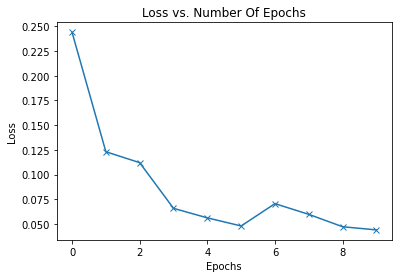

In [61]:
print("Loss for network with multiple (4) convolutional layer")
graph_loss(conv_4c2m)

Accuracy for network with multiple (4) convolutional layer


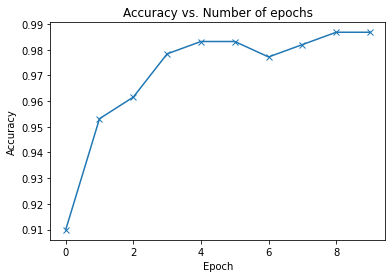

In [62]:
print("Accuracy for network with multiple (4) convolutional layer")
accuracy_graph(conv_4c2m)

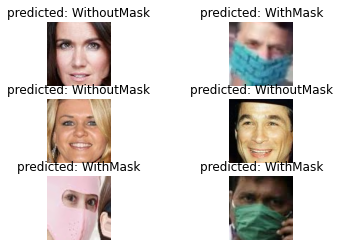

In [63]:
#making predictions on the test data 
Image_pred(test_image_paths[17:23],saved_conv_4c2m, show=True)

In [64]:
#Displaying the Classification report
classificationReport(saved_conv_4c2m)

100%|██████████| 509/509 [00:00<00:00, 159666.50it/s]

Reading from folder: 1
Reading from folder: 0


[[420  89]
 [  9 474]]
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       509
           1       0.84      0.98      0.91       483

    accuracy                           0.90       992
   macro avg       0.91      0.90      0.90       992
weighted avg       0.91      0.90      0.90       992



**3. Convolutional Neural Network with 6 convolution layers ,Batch Normalization , 2 max pooling with fully connected layer Sigmoid activation function**

In [65]:
#Defining the class for Model 3
class cnn_maskdetect_6convBatch(Img_Classification):
    def __init__(self):
        super().__init__()
        self.network_6convBatch = nn.Sequential(
            # input_shape = [64 , 3, 100 , 100]
            nn.Conv2d(3, 10, kernel_size=3, padding=1), #shape = [64 , 10, 100 , 100]
            nn.BatchNorm2d(10),
            nn.Conv2d(10, 32, kernel_size=3, stride=1, padding=1), #shape = [64 , 32, 100 , 100]
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), #shape = [64 , 64, 100 , 100]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #shape = [64 , 64, 50 , 50]
            
            nn.Conv2d(64, 100, kernel_size=3, stride=1, padding=1), #shape = [64 , 100, 100 , 100]
            nn.BatchNorm2d(100),
            nn.Conv2d(100, 128, kernel_size=3, padding=1), #shape = [64 , 128, 100 , 100]
            nn.BatchNorm2d(128), 
            nn.Conv2d(128, 200, kernel_size=3, stride=1, padding=1), #shape = [64 , 200, 50 , 50]
            nn.BatchNorm2d(200),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #shape = [64 , 200, 25 , 25]
            
            
            nn.Flatten(), 
            nn.Linear(200 * 25 * 25, 512),
            nn.Sigmoid(),
            nn.Linear(512, 256),
            nn.Sigmoid(),
            nn.Linear(256, 2)
        
        )
        
    def forward(self, inputs):
        return self.network_6convBatch(inputs)

In [66]:
# Model 3
model3_6convBatch = cnn_maskdetect_6convBatch()
model3_6convBatch.to(device)

cnn_maskdetect_6convBatch(
  (network_6convBatch): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(10, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(100, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): C

In [67]:
model3_6convBatch.eval()

cnn_maskdetect_6convBatch(
  (network_6convBatch): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(10, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(100, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): C

In [68]:
conv6Batch = [model_eval(model3_6convBatch, valDataloader)]
conv6Batch

[{'val_acc': 0.5084134340286255, 'val_loss': 0.6930851936340332}]

In [69]:
#fitting the model with 10 epochs 
conv6Batch = model_fit(10, 1e-3, model3_6convBatch, trainDataloader, valDataloader)

Epoch:  0
Epoch [0], train_loss: 0.3871, val_loss: 0.1835, val_acc: 0.9555
Epoch:  1
Epoch [1], train_loss: 0.1111, val_loss: 0.0848, val_acc: 0.9796
Epoch:  2
Epoch [2], train_loss: 0.0599, val_loss: 0.0499, val_acc: 0.9820
Epoch:  3
Epoch [3], train_loss: 0.0410, val_loss: 0.0358, val_acc: 0.9892
Epoch:  4
Epoch [4], train_loss: 0.0310, val_loss: 0.0309, val_acc: 0.9928
Epoch:  5
Epoch [5], train_loss: 0.0287, val_loss: 0.0257, val_acc: 0.9928
Epoch:  6
Epoch [6], train_loss: 0.0239, val_loss: 0.0307, val_acc: 0.9904
Epoch:  7
Epoch [7], train_loss: 0.0204, val_loss: 0.0230, val_acc: 0.9928
Epoch:  8
Epoch [8], train_loss: 0.0191, val_loss: 0.0222, val_acc: 0.9940
Epoch:  9
Epoch [9], train_loss: 0.0159, val_loss: 0.0226, val_acc: 0.9904


In [70]:
model_save_name_6convBatch = 'MaskDetectModel3.pth'
path_6convBatch = F"/content/drive/MyDrive/{model_save_name_6convBatch}"


In [71]:
#saving the model on google drive
torch.save(model3_6convBatch,path_6convBatch)

In [72]:
saved_conv_6convBatch = torch.load(path_6convBatch)

In [73]:
saved_conv_6convBatch.eval()

cnn_maskdetect_6convBatch(
  (network_6convBatch): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(10, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(100, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): C

Loss for network with multiple (6) convolutional layer


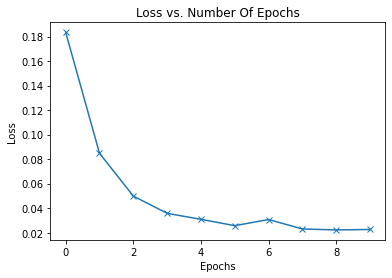

In [74]:
print("Loss for network with multiple (6) convolutional layer")
graph_loss(conv6Batch)

Accuracy for network with multiple (6) convolutional layer


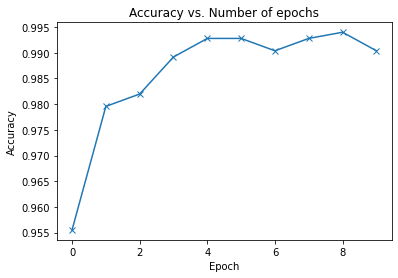

In [75]:
print("Accuracy for network with multiple (6) convolutional layer")
accuracy_graph(conv6Batch)

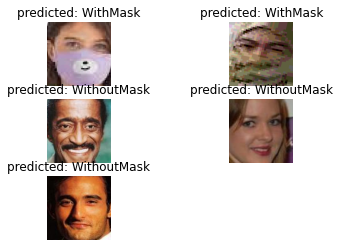

In [76]:
#making predictions on the images in test data 
Image_pred(test_image_paths[175:180],saved_conv_6convBatch, show=True)

In [77]:
#Displaying the Classification report
classificationReport(saved_conv_6convBatch)

100%|██████████| 509/509 [00:00<00:00, 131971.36it/s]

Reading from folder: 1
Reading from folder: 0


[[480  29]
 [  0 483]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       509
           1       0.94      1.00      0.97       483

    accuracy                           0.97       992
   macro avg       0.97      0.97      0.97       992
weighted avg       0.97      0.97      0.97       992

